In [1]:
import sys, os
COLAB = 'google.colab' in sys.modules 
if COLAB and 'procgen-tools' not in os.getcwd():
    os.system("git clone https://github.com/UlisseMini/procgen-tools")
    os.chdir('procgen-tools')
    %pip install -r requirements.txt

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from procgen import ProcgenGym3Env
import envs.maze as maze
import models.misgen
from models.misgen import InterpretableImpalaModel
from models.policy import CategoricalPolicy
import torch
from IPython import display

building procgen...done


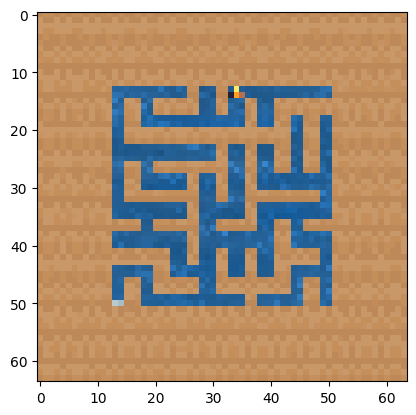

In [3]:
# num is the number of environments to create in the vec env
# num_levels is the number of levels to sample from (0 for infinite, 1 for deterministic)
venv = ProcgenGym3Env(
    num=1, env_name='maze', num_levels=0, start_level=0,
    distribution_mode='hard', num_threads=1, render_mode="rgb_array",
)
venv = maze.wrap_venv(venv)
obs = venv.reset()
# plot all the envs in the vectorized env
for i in range(obs.shape[0]):
    plt.imshow(obs[i].transpose(1, 2, 0))
    plt.show()

## Move the cheese

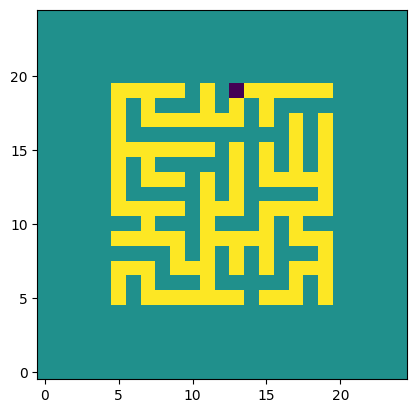

In [4]:
state_bytes = venv.env.callmethod("get_state")[0] # first in venv
state_vals = maze.parse_maze_state_bytes(state_bytes)
grid = maze.get_grid(state_vals)
cheese_row, cheese_col = maze.get_cheese_pos(grid)
plt.imshow(grid, origin='lower')

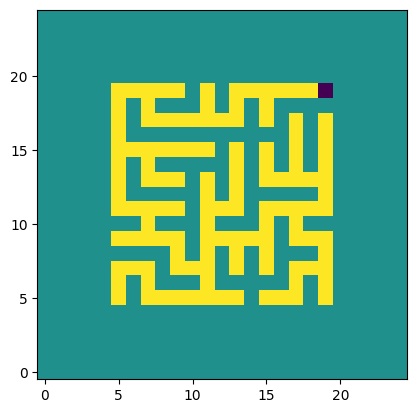

In [5]:
tr = next(i for i in range(len(grid)-1, 0, -1) if grid[i][i] == maze.EMPTY)
maze.set_cheese_pos(grid, tr, tr)
plt.imshow(grid, origin='lower')

## Check that maze is in-distribution

The maze is generated using a variant of [Kruskal's algorithm](https://weblog.jamisbuck.org/2011/1/3/maze-generation-kruskal-s-algorithm). The algorithm results in some constraints on generated mazes we want to uphold, in order to stay in-distribution.
1. Squares where the row and column indices are both odd, e.g. (1,1), must always be blocked.
2. Squares where the row and column indices are both even, e.g. (0,0), must always be open.
3. Squares where the row and column indices are (odd, even) or (even, odd) may be open or blocked.
4. The maze must be fully-connected, i.e. there must be a path from every open square to every other open square.
5. The maze must not have any loops or cycles, i.e. there must be exactly one path between any two open squares.

In [6]:
# Make a copy of the grid without the cheese
g = maze.inner_grid(grid).copy()
r, c = maze.get_cheese_pos(g)
g[r, c] = maze.EMPTY

# Assert invariants
assert (g[1::2, 1::2] == maze.BLOCKED).all(), "Squares where row,col are both odd must always be blocked"
assert (g[0::2, 0::2] == maze.EMPTY).all(), "Squares where row,col are both even must always be empty"
assert maze.fully_connected(g), "Maze must be fully connected"
# TODO: Check exactly one path between each pair of squares

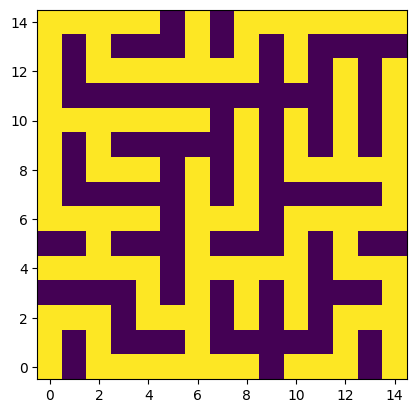

In [7]:
plt.imshow(g, origin='lower')

## Overwrite the env state

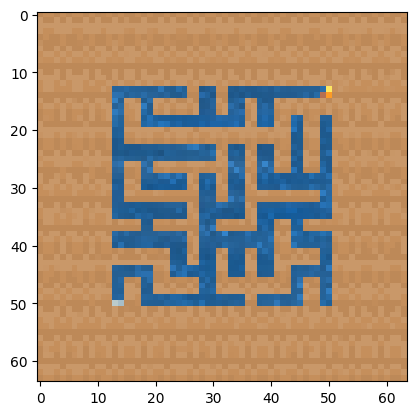

In [8]:
maze.set_grid(state_vals, grid)
state_bytes = maze.serialize_maze_state(state_vals)
venv.env.callmethod("set_state", [state_bytes])

obs = venv.reset()
plt.imshow(obs[0].transpose(1, 2, 0))

## Run the model on the new maze

In [9]:
if COLAB:
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

In [10]:
# download from https://drive.google.com/file/d/1db1qJn_ZM49CUcA1k7uSMdsdiAQ4eR5a/view?usp=share_link
checkpoint = torch.load('./model_200015872.pth', map_location=torch.device('cpu'))

# CURSED. scale varies between models trained on the lauro vs. master branch. 
import models.misgen
models.misgen.scale = checkpoint['model_state_dict']['embedder.block1.conv.weight'].shape[0]//16

In [11]:
model = InterpretableImpalaModel(in_channels=3)

policy = CategoricalPolicy(model, action_size=venv.action_space.n)
policy.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

KeyboardInterrupt: 

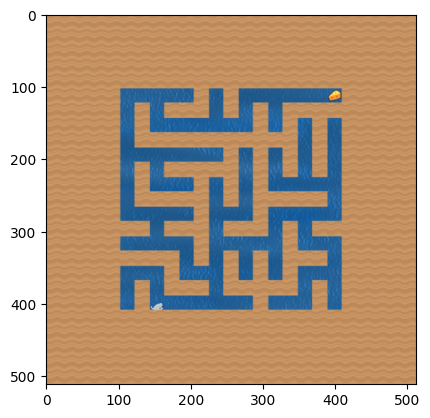

In [12]:
done = np.zeros(venv.num_envs)
obs = venv.reset()

while not all(done):
    policy.eval()
    p, v = policy(torch.FloatTensor(obs))
    act = p.sample().numpy()
    obs, rew, done, info = venv.step(act)

    if not all(done): # don't show last frame (new maze)
        # plt.imshow(obs[0].transpose(1,2,0)) # agent view
        plt.imshow(info[0]['rgb'])
        display.display(plt.gcf())
        display.clear_output(wait=True)